# Training a network for jet images

This Jupyter Notebook will train and test a network for jet images. The data used is created in examples/process_jet_images 

to create the dataset that is used here)

## Preparing the data

Note: You have to change the path to the directory where your processed files are. 

In [32]:
import pandas as pd

# Change this path to point to where you have stored the data: 
train = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/shuffled/images/jet_images_LAGAN_images_bg_train_shuffled.pkl')
valid = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/shuffled/images/jet_images_LAGAN_images_bg_valid_shuffled.pkl')
test = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/shuffled/images/jet_images_LAGAN_images_bg_test_shuffled.pkl')

Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

## Setting up the network

### Inputting the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later). Note that we have train in both cases pga autoencoder

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train.values, dtype=torch.float), torch.tensor(train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(valid.values, dtype=torch.float), torch.tensor(valid.values, dtype=torch.float))
test_ds = TensorDataset(torch.tensor(test.values, dtype=torch.float), torch.tensor(test.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [34]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs) #*2 innan
test_dl = DataLoader(test_ds, batch_size=bs)

dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [36]:
class AE_model_3H_100(nn.Module):
    def __init__(self, n_features=625):
        super(AE_model_3H_100, self).__init__()
        
        self.en1 = nn.Linear(n_features, 300)
        self.en2 = nn.Linear(300, 100)
        self.de1 = nn.Linear(100, 300)
        self.de2 = nn.Linear(300, n_features)
        
        #self.en1 = nn.Linear(n_features, 625)
        #self.en2 = nn.Linear(625, 625)
        #self.de1 = nn.Linear(625, 625)
        #self.de2 = nn.Linear(625, n_features)
        
        self.leakyrelu = nn.LeakyReLU()

    def encode(self, x):
        return self.en2(self.leakyrelu(self.en1(x)))

    def decode(self, x):
        return self.de2(self.leakyrelu(self.de1(self.leakyrelu(x))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'text'

class AE_model_7H_100(nn.Module):
    def __init__(self, n_features=625):
        super(AE_model_7H_100, self).__init__()
        
        self.en1 = nn.Linear(n_features, 500)
        self.en2 = nn.Linear(500, 350)
        self.en3 = nn.Linear(350, 200)
        self.en4 = nn.Linear(200, 100)
        self.de1 = nn.Linear(100, 200)
        self.de2 = nn.Linear(200, 350)
        self.de3 = nn.Linear(350, 500)
        self.de4 = nn.Linear(500, n_features)
        
        self.leakyrelu = nn.LeakyReLU()

    def encode(self, x):
        return self.en4(self.leakyrelu(self.en3(self.leakyrelu(self.en2(self.leakyrelu(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.leakyrelu(self.de3(self.leakyrelu(self.de2(self.leakyrelu(self.de1(self.leakyrelu(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'text'
    
class AE_model_7H_50(nn.Module):
    def __init__(self, n_features=625):
        super(AE_model_7H_50, self).__init__()
        
        self.en1 = nn.Linear(n_features, 500)
        self.en2 = nn.Linear(500, 350)
        self.en3 = nn.Linear(350, 200)
        self.en4 = nn.Linear(200, 50)
        self.de1 = nn.Linear(50, 200)
        self.de2 = nn.Linear(200, 350)
        self.de3 = nn.Linear(350, 500)
        self.de4 = nn.Linear(500, n_features)
        
        self.leakyrelu = nn.LeakyReLU()

    def encode(self, x):
        return self.en4(self.leakyrelu(self.en3(self.leakyrelu(self.en2(self.leakyrelu(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.leakyrelu(self.de3(self.leakyrelu(self.de2(self.leakyrelu(self.de1(self.leakyrelu(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'text'
    
model = AE_model_7H_50()
model.to('cpu')

AE_model_7H_50(
  (en1): Linear(in_features=625, out_features=500, bias=True)
  (en2): Linear(in_features=500, out_features=350, bias=True)
  (en3): Linear(in_features=350, out_features=200, bias=True)
  (en4): Linear(in_features=200, out_features=50, bias=True)
  (de1): Linear(in_features=50, out_features=200, bias=True)
  (de2): Linear(in_features=200, out_features=350, bias=True)
  (de3): Linear(in_features=350, out_features=500, bias=True)
  (de4): Linear(in_features=500, out_features=625, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [37]:
from fastai.metrics import mse

loss_func = nn.MSELoss()
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

## Alternative 1: Training a new network

### Choosing the learning rate

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.001737800776027143)

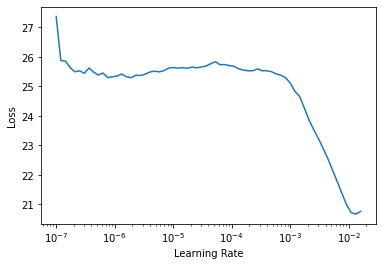

In [38]:
from fastai.callback import schedule

#lr_min, lr_steep = learn.lr_find()
learn.lr_find()

#print('Learning rate with the minimum loss:', lr_min)
#print('Learning rate with the steepest gradient:', lr_steep)

### Training the network

In [39]:
import time

start = time.perf_counter() # Starts timer
#learn.fit_one_cycle(n_epoch=30, lr_max=lr_steep)
learn.fit_one_cycle(n_epoch=20)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 1.8735990524291992, 1.7036715745925903, '01:10']
[0, 1.8735990524291992, 1.7036715745925903, '01:10']
[1, 0.6717211604118347, 0.6932295560836792, '01:07']
[1, 0.6717211604118347, 0.6932295560836792, '01:07']
[2, 0.4568181037902832, 0.4649498462677002, '01:08']
[2, 0.4568181037902832, 0.4649498462677002, '01:08']
[3, 0.3596265912055969, 0.37401914596557617, '01:10']
[3, 0.3596265912055969, 0.37401914596557617, '01:10']
[4, 0.27338624000549316, 0.32202523946762085, '01:44']
[4, 0.27338624000549316, 0.32202523946762085, '01:44']
[5, 0.22503715753555298, 0.36265960335731506, '01:07']
[5, 0.22503715753555298, 0.36265960335731506, '01:07']
[6, 0.1969689279794693, 0.20121625065803528, '01:07']
[6, 0.1969689279794693, 0.20121625065803528, '01:07']
[7, 0.16835002601146698, 0.23167367279529572, '01:08']
[7, 0.16835002601146698, 0.23167367279529572, '01:08']
[8, 0.14554081857204437, 0.17966990172863007, '01:08']
[8, 0.14554081857204437, 0.17966990172863007, '01:08']
[9, 0.12704481184482574, 0

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

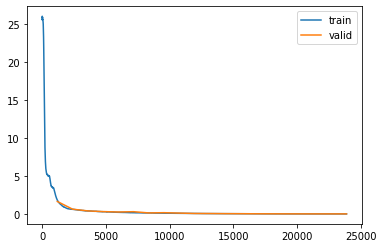

In [40]:
recorder.plot_loss()

Saving the trained network in folder /models/

In [41]:
#learn.save('bg_all_img_625-625-625-625-625')
#learn.save('bg_all_img_625-300-100-300-625_shuffled')
learn.save('bg_all_img_625-500-350-200-50-200-350-500-625_shuffled')

Path('models/bg_all_img_625-500-350-200-50-200-350-500-625_shuffled.pth')

## Alternative 2: Using a pre-trained network

In [73]:
learn.load('bg_all_img_625-625-625-625-625')
#learn.load('bg_all_img_625-300-100-300-625')

## Evaluation of network

In [42]:
learn.validate()

(#1) [0.07341761887073517]

In [43]:
test_preds, test_targs = learn.get_preds(dl=test_dl)
mse = np.zeros(len(test_targs))
for i in range(len(test_targs)):
    mse[i] = loss_func(test_preds[i],test_targs[i])

print(np.mean(mse))

0.0730046449530721


In [44]:
path_signal = '/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/not shuffled/images/jet_images_LAGAN_images_signal.pkl'
df_signal = pd.read_pickle(path_signal)
signal_ds = TensorDataset(torch.tensor(df_signal.values, dtype=torch.float), torch.tensor(df_signal.values, dtype=torch.float))
signal_dl = DataLoader(signal_ds, batch_size=bs)

signal_preds, signal_targs = learn.get_preds(dl=signal_dl)
mse_signal = np.zeros(len(signal_targs))
for i in range(len(signal_targs)):
    mse_signal[i] = loss_func(signal_preds[i],signal_targs[i])
    
print(np.mean(mse_signal))

0.03453647670468853


## Preparing for analysis

In [45]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [48]:
df_test_preds = pd.DataFrame(test_preds, columns=test.columns)
df_test_preds.to_pickle(os.path.join(save_dir,'bg_all_img_625-500-350-200-50-200-350-500-625_bg_test_preds_shuffled.pkl'))

df_signal_preds = pd.DataFrame(signal_preds, columns=df_signal.columns)
df_signal_preds.to_pickle(os.path.join(save_dir,'bg_all_img_625-500-350-200-50-200-350-500-625_signal_test_preds_shuffled.pkl'))

In [56]:
learner.export(learn,'fname=export.pkl')

AttributeError: 'DataLoader' object has no attribute 'new'